In [1]:
import pandas as pd
import numpy as np
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings("ignore")
from sklearn.mixture import GaussianMixture
import os
import ot
import pickle
import argparse
import Levenshtein
import itertools
import umap
from sklearn.decomposition import PCA
from helper_functions import *
##### input args

PROJECT = "gs-mrd"
release_version = "10062024_modified_092024"
merge_version = "20240914"
data_version = "20240924"
outdir = "/media/hieunguyen/HNSD_mini/outdir"
path_to_main_output = os.path.join(outdir, PROJECT, "data_analysis")
path_to_03_output = os.path.join(path_to_main_output, "03_output")
os.system(f"mkdir -p {path_to_03_output}")

files = [item for item in pathlib.Path(os.path.join("all_samples", data_version)).glob("*.csv")]
featuredf = dict()
for file in files:
    feature_name = file.name.split(".csv")[0]
    featuredf[feature_name] = pd.read_csv(file)

metadata = pd.read_csv(f"./metadata/{data_version}/metadata.csv")

##### check if the SampleID and the metadata match
assert len([item for item in metadata.SampleID.unique() if item in featuredf["EM"].SampleID.unique()]) == featuredf["EM"].shape[0]

# Some visualization on the data

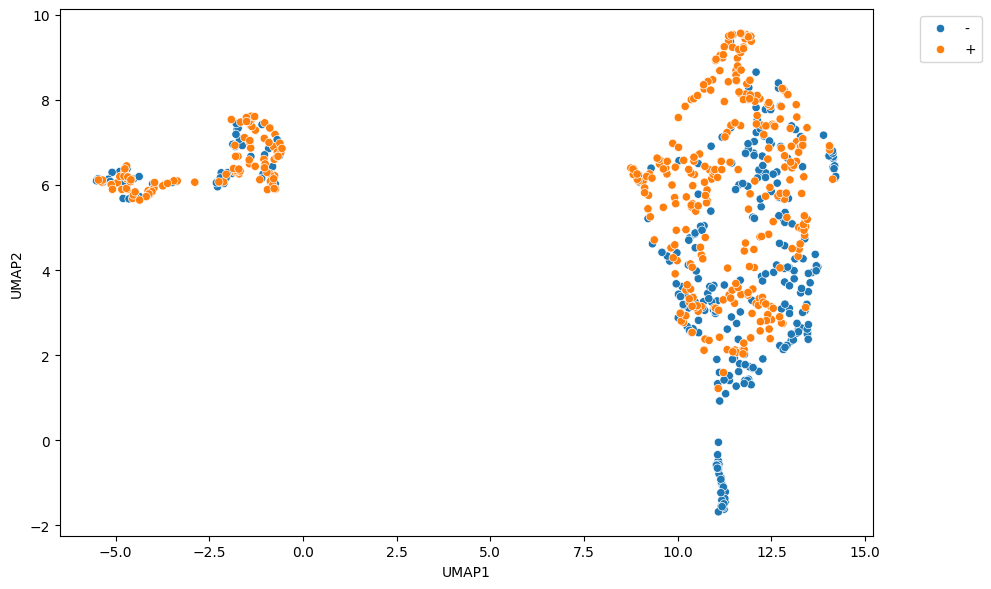

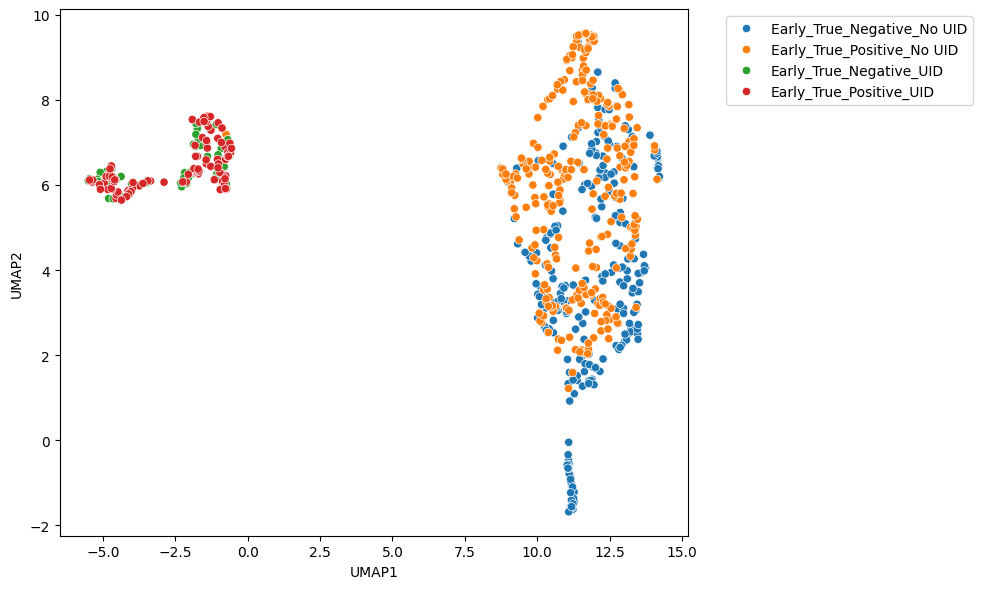

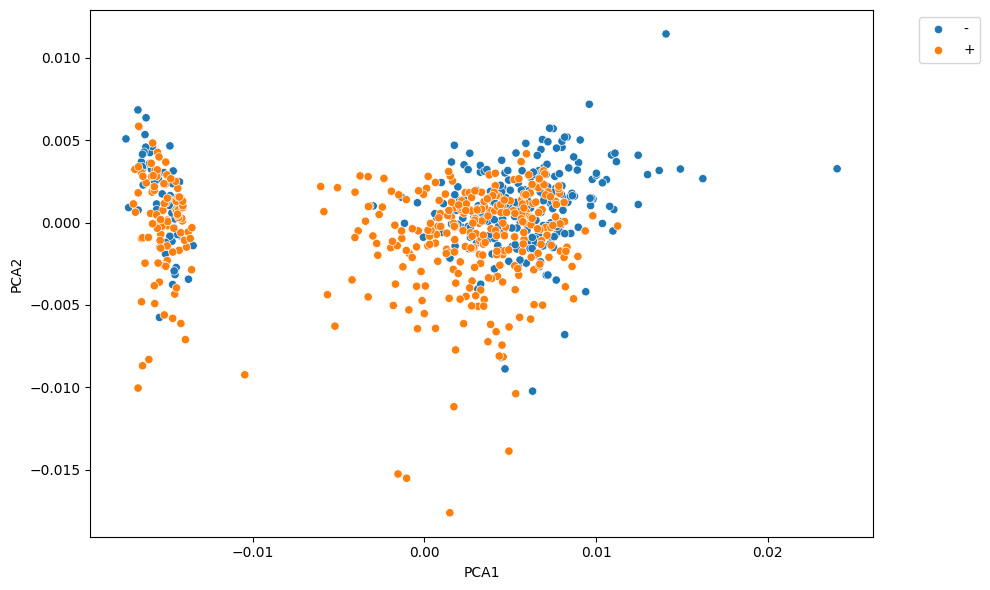

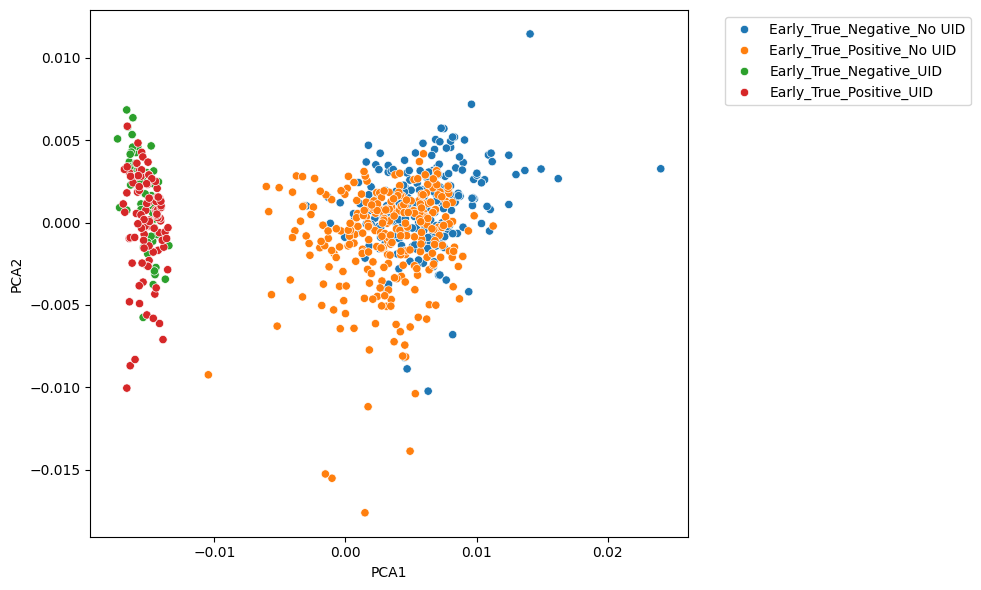

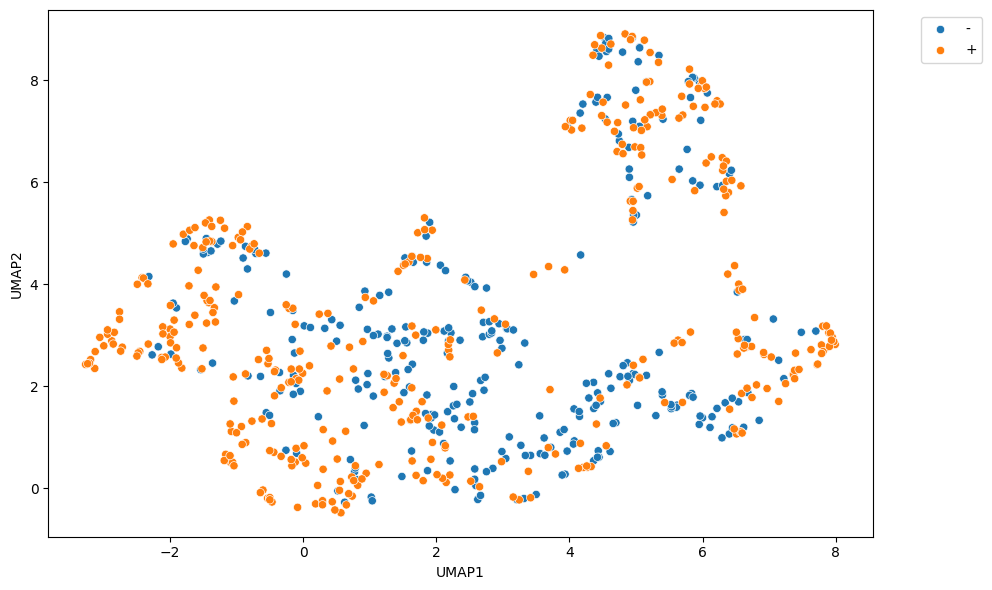

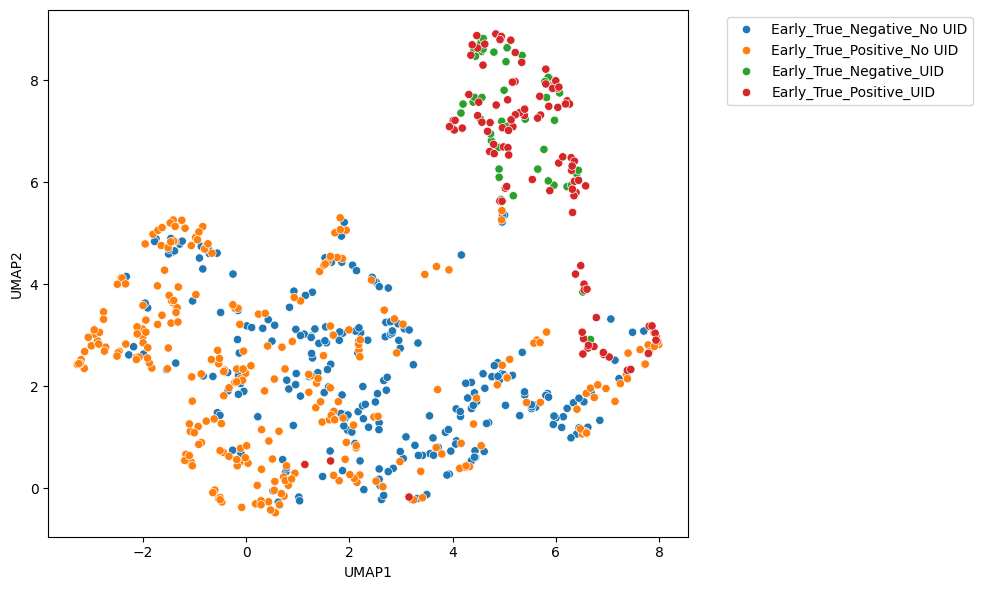

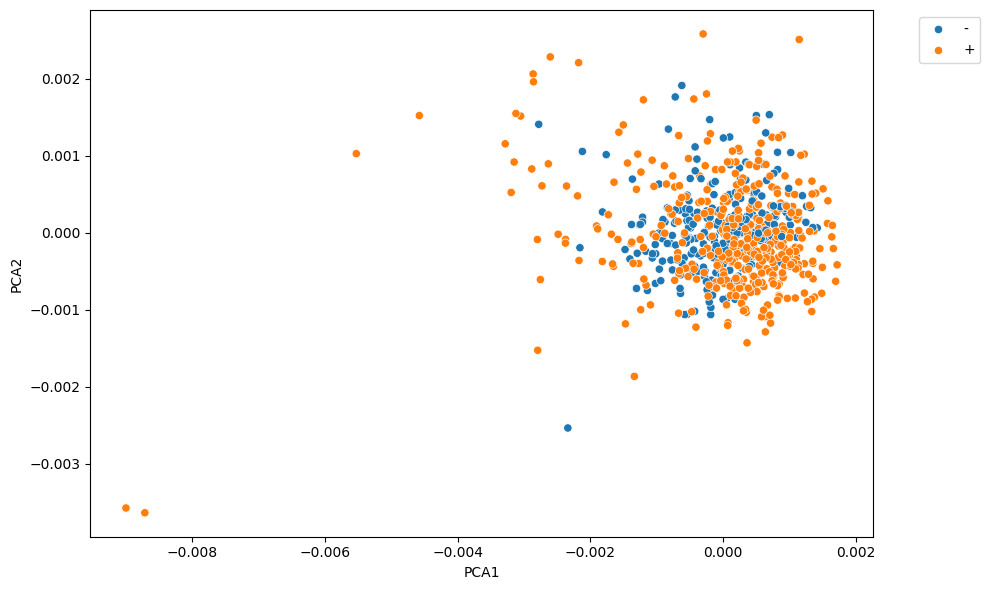

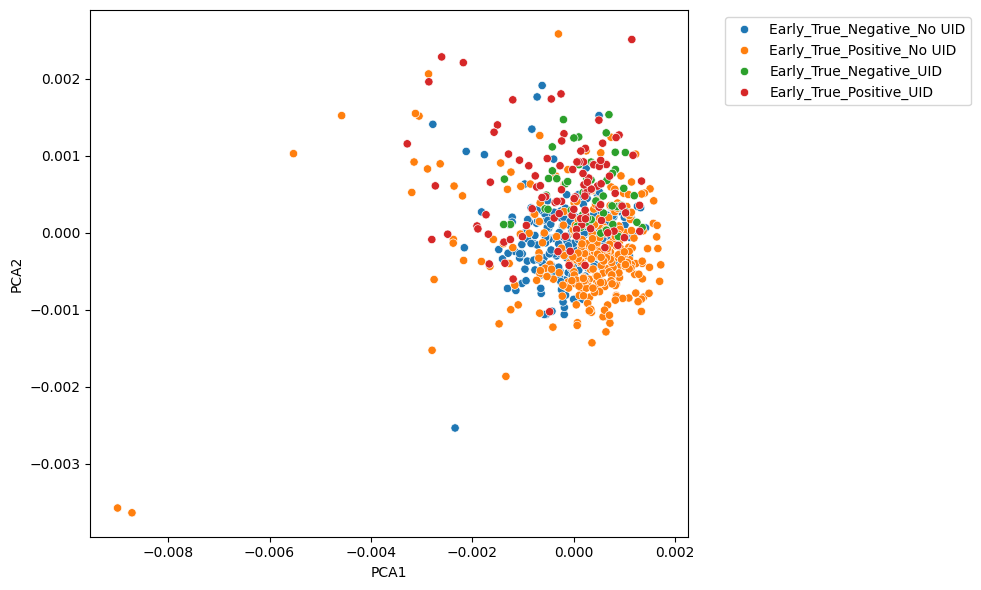

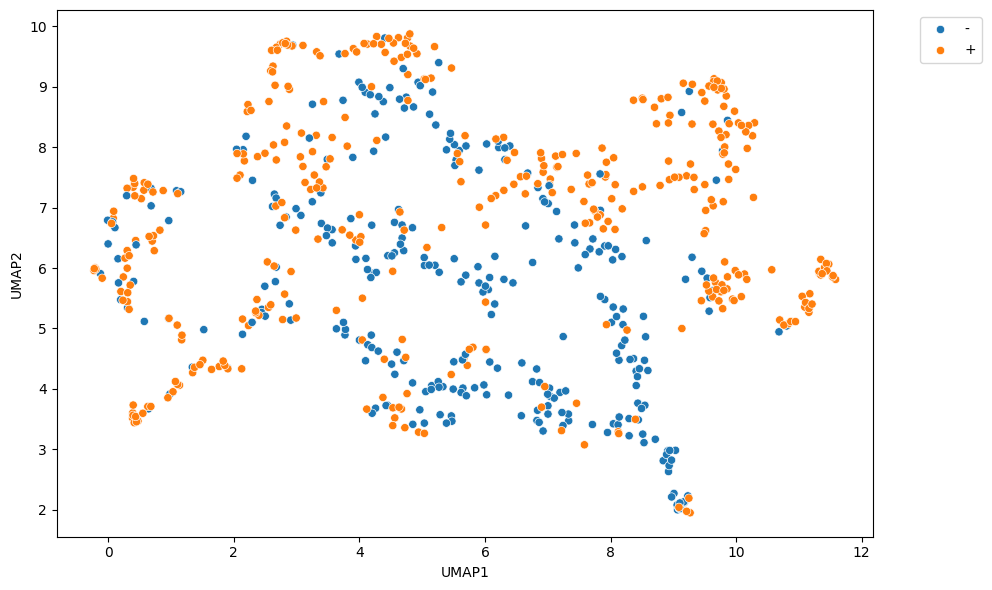

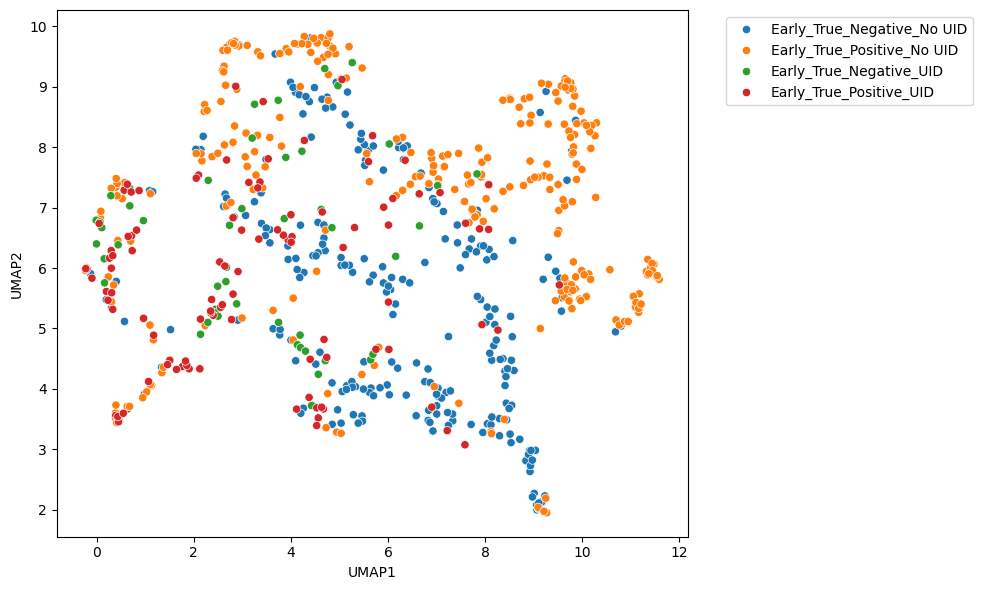

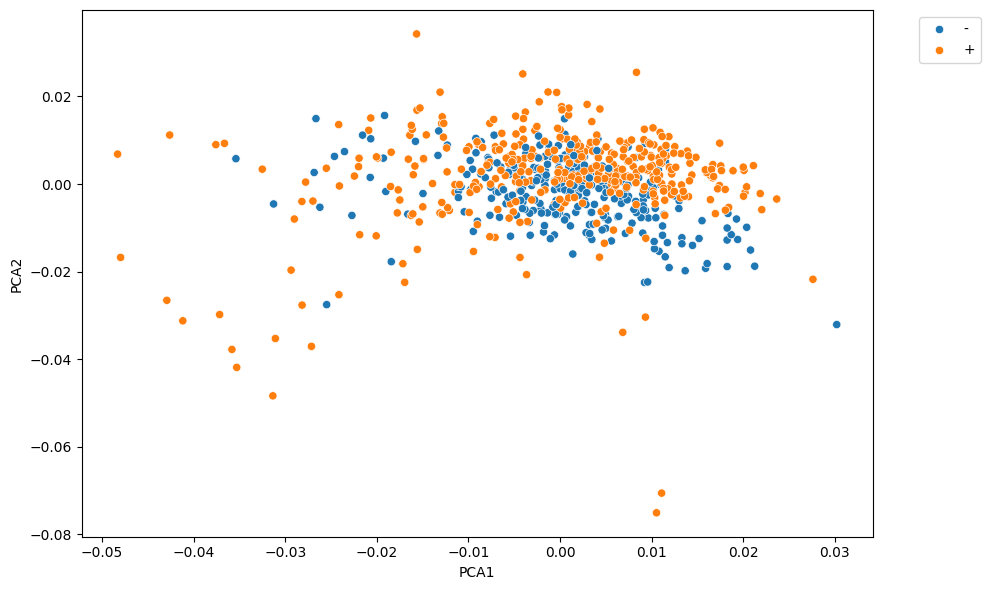

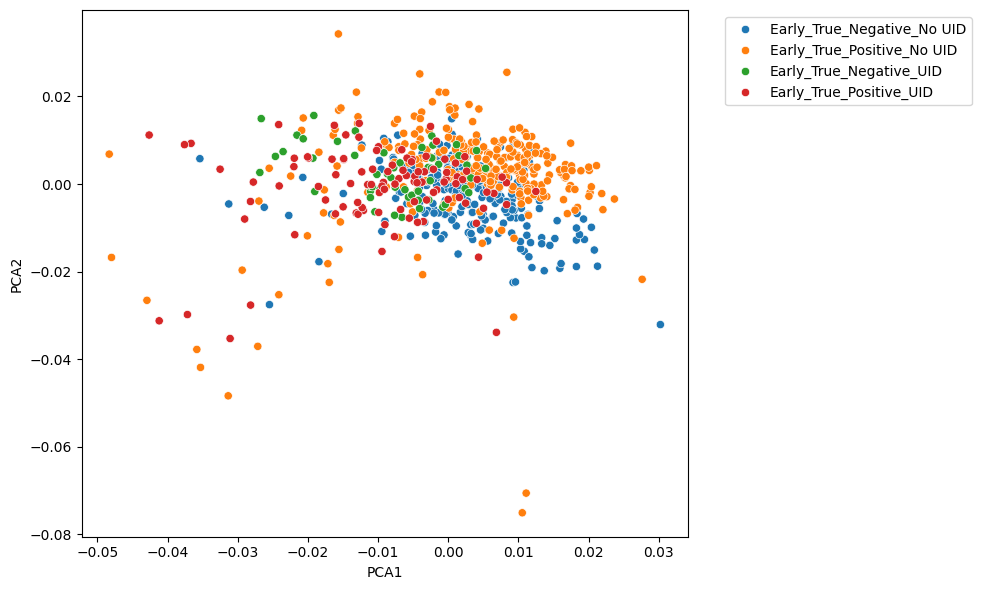

In [2]:
umapdf = dict()
pcadf = dict()

for f in ["EM", "NUCLEOSOME", "FLEN"]:
    maindf = featuredf[f].copy()
    umap_reducer = umap.UMAP()
    pca_reducer = PCA(n_components=2)

    umap_res = umap_reducer.fit_transform(maindf.iloc[:, 1:].to_numpy())
    pca_res = pca_reducer.fit_transform(maindf.iloc[:, 1:].to_numpy())

    umapdf[f] = pd.DataFrame(umap_res, columns=["UMAP1", "UMAP2"])
    umapdf[f]["SampleID"] = maindf.SampleID.values

    pcadf[f]  = pd.DataFrame(pca_res, columns=["PCA1", "PCA2"])
    pcadf[f]["SampleID"] = maindf.SampleID.values

    umapdf[f] = umapdf[f].merge(metadata, right_on = "SampleID", left_on = "SampleID")
    pcadf[f] = pcadf[f].merge(metadata, right_on = "SampleID", left_on = "SampleID")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data = umapdf[f], x = "UMAP1", y = "UMAP2", hue = "true_label")
    figname = f"UMAP_grouped_by_true_label.{f}.svg"
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_03_output, figname), format='svg')
    # plt.show()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data = umapdf[f], x = "UMAP1", y = "UMAP2", hue = "sheet")
    figname = f"UMAP_grouped_by_sheet.{f}.svg"
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_03_output, figname), format='svg')
    # plt.show()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data = pcadf[f], x = "PCA1", y = "PCA2", hue = "true_label")
    figname = f"PCA_grouped_by_true_label.{f}.svg"
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_03_output, figname), format='svg')
    # plt.show()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data = pcadf[f], x = "PCA1", y = "PCA2", hue = "sheet")
    figname = f"PCA_grouped_by_sheet.{f}.svg"
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_03_output, figname), format='svg')
    # plt.show()


In [3]:
path_to_main_src = "/media/hieunguyen/HNSD01/src/gs-mrd"
path_to_model_files = f"{path_to_main_src}/model_files/{release_version}"
motif_order = pd.read_csv("motif_order.csv").motif_order.to_list()

##### load cut-off values for all features
cutoffdf = pd.read_csv(os.path.join(path_to_model_files, "cutoff.csv"))

##### load reference values for all features (healthy references)
ref = dict()

em_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_EM.csv")
em_ref.columns = ["motif", "Healthy"]
ref["EM"] = em_ref.copy()

flen_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_FLEN.csv")
flen_ref.columns = ["FLEN", "Healthy"]
ref["FLEN"] = flen_ref.copy()

nuc_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_NUCLEOSOME.csv")
nuc_ref.columns = ["Nucleosome", "Healthy"]
ref["NUCLEOSOME"] = nuc_ref.copy()


In [4]:
all_samples = featuredf["EM"].SampleID.to_list()
final_features = dict()
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    inputdf = featuredf[f].set_index("SampleID").T.copy()
    inputdf["Healthy"] = ref[f]["Healthy"].values
    for sampleid in all_samples:
        inputdf[sampleid] = abs(inputdf[sampleid] - inputdf["Healthy"])
    input_scoredf = inputdf.drop("Healthy", axis = 1).sum().reset_index()
    input_scoredf.columns = ["SampleID", f"{f}_score"]
    input_scoredf = input_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    final_features[f"{f}_score"] = input_scoredf

##### OT distance
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    barycenter = pd.read_csv(f"{path_to_model_files}/Healthy_OT_{f}_baryl2.csv")
    bary_l2 = barycenter.baryl2.to_numpy()
    ot_scoredf = pd.DataFrame(data = all_samples, columns = ["SampleID"])
    ot_scoredf[f"OT_{f}"] = ot_scoredf["SampleID"].apply(lambda x: 
        calculate_ot_distance_to_healthy_nuc(x, 
                                             bary_l2, 
                                             featuredf[f].set_index("SampleID").T, 
                                             n = featuredf[f].shape[1] - 1))
    ot_scoredf = ot_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    final_features[f"OT_{f}"] = ot_scoredf
    
##### NMF distance
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    nmf_signal_cancer = pd.read_csv(f"{path_to_model_files}/NMF_{f}_cancer_signal.csv").nmf_signal_cancer.to_list()[0]
    nmf_signal_cancer -= 1
    nmf_model = pickle.load(open(f"{path_to_model_files}/NMF_{f}.sav", 'rb'))
    W = nmf_model.transform(featuredf[f].set_index("SampleID").to_numpy())
    H = nmf_model.components_
    nmf_scoredf = pd.DataFrame(data = W, columns = ["V1", "V2"])
    nmf_scoredf["SampleID"] = featuredf[f].SampleID.to_list()
    nmf_scoredf["V1_scale"] = nmf_scoredf[["V1", "V2"]].apply(lambda x: x[0]/sum(x), axis = 1)
    nmf_scoredf["V2_scale"] = nmf_scoredf[["V1", "V2"]].apply(lambda x: x[1]/sum(x), axis = 1)
    nmf_scoredf[f"NMF_{f}"] = nmf_scoredf[["V1_scale", "V2_scale"]].apply(lambda x: x[nmf_signal_cancer], axis = 1)
    nmf_scoredf = nmf_scoredf[["SampleID", f"NMF_{f}"]].copy()
    nmf_scoredf = nmf_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    final_features[f"NMF_{f}"] = nmf_scoredf.copy()

final_features["ichorCNA"] = featuredf["IchorCNA"]
outputdf = pd.DataFrame(data = metadata["SampleID"].to_list(), columns = ["SampleID"])
for feat in final_features.keys():
    tmpdf = final_features[feat][["SampleID", feat]]
    tmpdf.columns = ["SampleID", feat]
    outputdf = outputdf.merge(tmpdf, right_on = "SampleID", left_on = "SampleID")

outputdf = outputdf.merge(metadata, right_on = "SampleID", left_on = "SampleID")

old_batch_outputdf = pd.read_csv(f"{path_to_model_files}/outputdf_data_version_{merge_version}.csv")

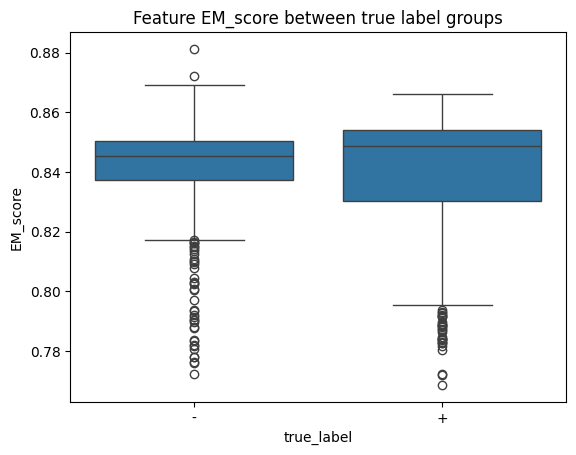

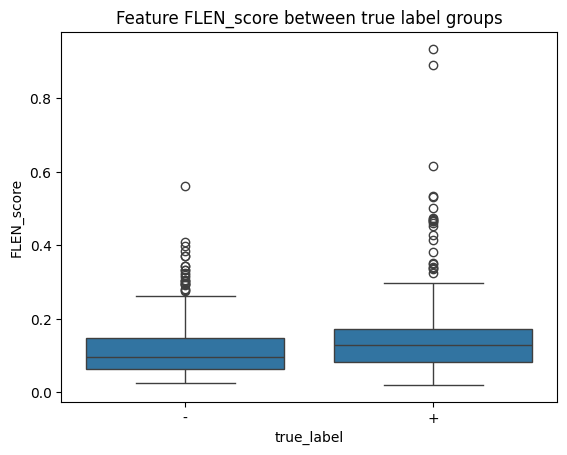

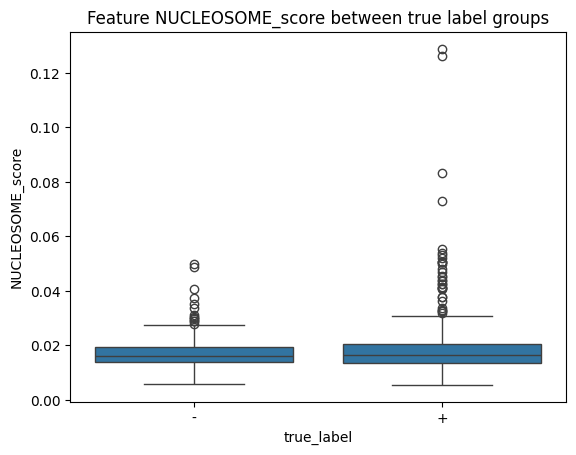

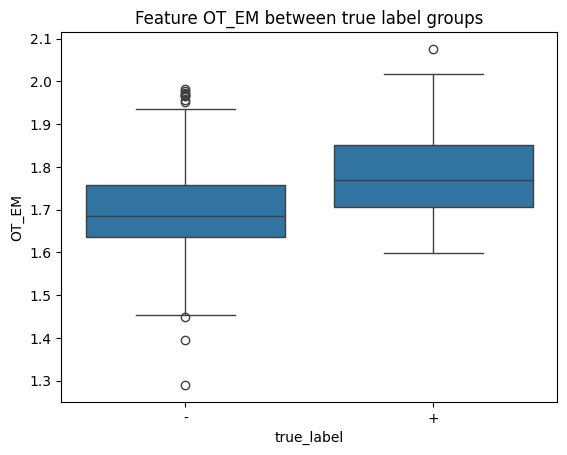

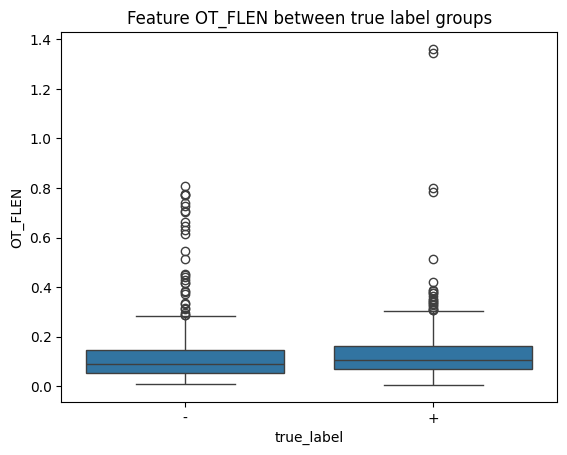

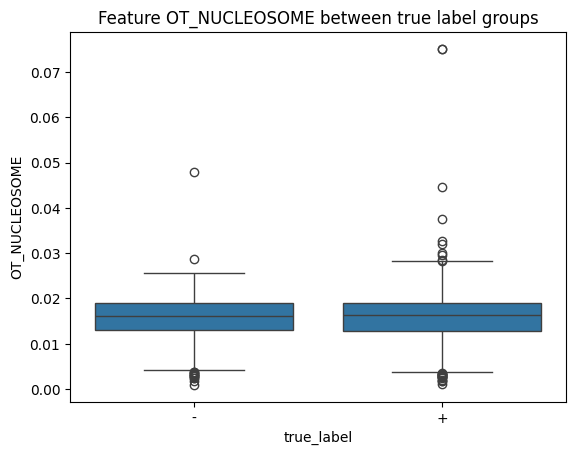

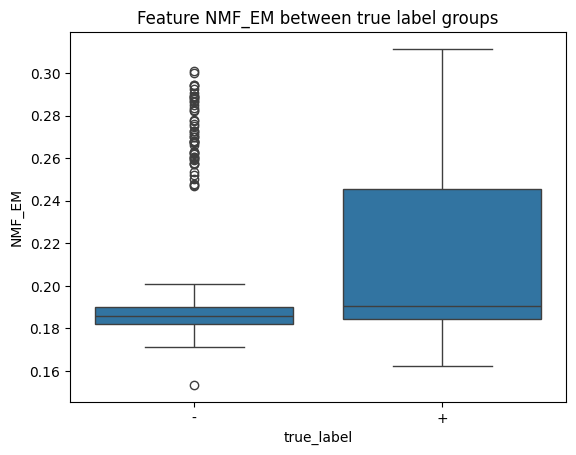

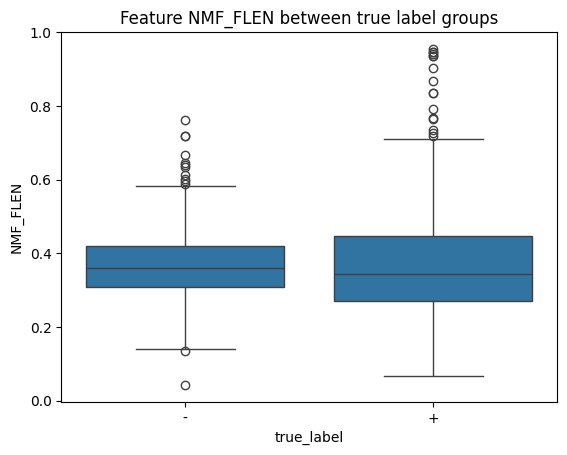

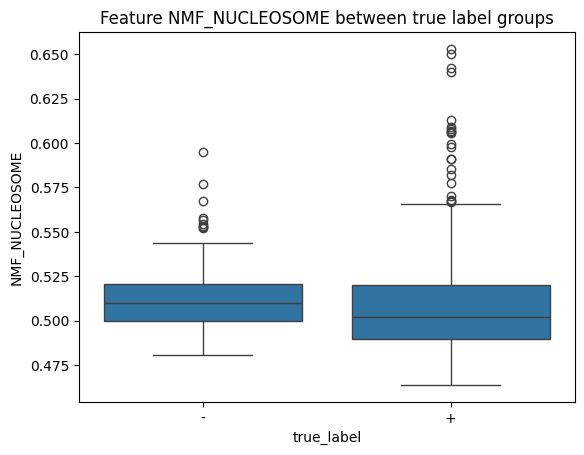

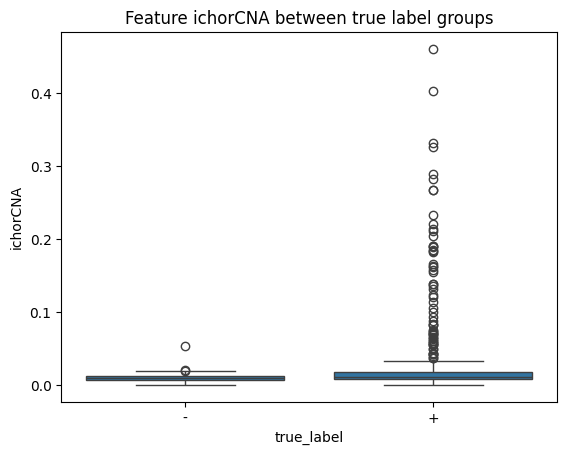

In [5]:
for f in final_features.keys():
    sns.boxplot(data = outputdf, x = "true_label", y = f)
    plt.title(f"Feature {f} between true label groups")
    plt.show()

In [6]:
outputdf["version"] = "new_data"
old_batch_outputdf["version"] = "old_data"

all_features = list(final_features.keys()) 
outputdf = outputdf[all_features + ["Cancer", "true_label", "version"]]

old_batch_outputdf = old_batch_outputdf[all_features + ["Cancer", "True label", "version"]]
old_batch_outputdf.columns = all_features + ["Cancer", "true_label", "version"]

mergedf = pd.concat([outputdf, old_batch_outputdf])

In [7]:
mergedf

,EM_score,FLEN_score,NUCLEOSOME_score,OT_EM,OT_FLEN,OT_NUCLEOSOME,NMF_EM,NMF_FLEN,NMF_NUCLEOSOME,ichorCNA,Cancer,true_label,version
0,0.814988,0.151329,0.017856,1.583061,0.275231,0.016008,0.198473,0.378331,0.523749,0.015890,Breast,-,new_data
1,0.847204,0.370751,0.025508,1.622849,0.706957,0.025143,0.179340,0.294839,0.521156,0.000000,Breast,-,new_data
2,0.847242,0.151181,0.014750,1.682201,0.182006,0.018501,0.182952,0.260202,0.489000,0.006024,Breast,-,new_data
3,0.841125,0.290928,0.022173,1.786056,0.373184,0.023850,0.186244,0.165715,0.503111,0.006342,Breast,-,new_data
4,0.840380,0.184422,0.017348,1.633979,0.312606,0.017366,0.183061,0.360977,0.519887,0.053230,Breast,-,new_data
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0.046437,0.085438,0.017347,0.008544,0.053896,0.009419,0.512645,0.460688,0.491602,0.000000,Healthy,-,old_data
384,0.072670,0.196860,0.015959,0.076532,0.121226,0.011653,0.490125,0.564874,0.519589,0.011020,CRC,-,old_data
385,0.044404,0.053199,0.010407,0.013207,0.052598,0.006447,0.532670,0.350188,0.513780,0.015930,Lung,+,old_data
386,0.031426,0.033043,0.012907,0.033559,0.025369,0.006837,0.514152,0.407157,0.494576,0.010620,Healthy,-,old_data


<Axes: xlabel='true_label', ylabel='OT_NUCLEOSOME'>

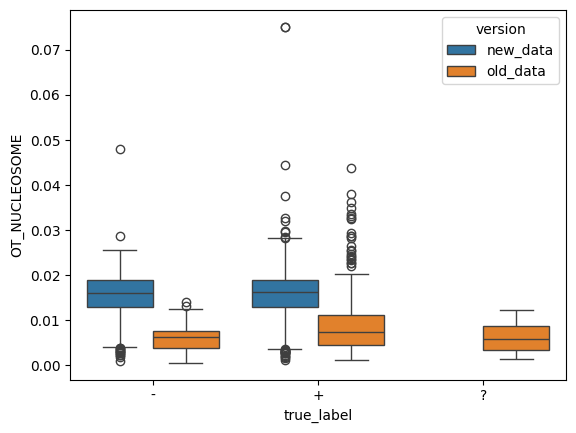

In [11]:
f = "OT_NUCLEOSOME"

sns.boxplot(data = mergedf, x = "true_label", y = f, hue = "version")